# N-Body Quadtree Tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound

In [2]:
def megno_whfast_simulation(par):
    
    a, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 5.
    sim.add(m=1.) # Star
    sim.add(m=0.000954, a=5.204, M=0.600, omega=0.257, e=0.048)
    sim.add(m=0.000285, a=a, M=0.871, omega=1.616, e=e)
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20.
    
    try:
        sim.integrate(5e3 * 2.*np.pi, exact_finish_time=0) # integrate for 500 years, integrating to the nearest
        #timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno() 
        return megno
    
    except rebound.Escape:
        return 50. # At least one particle got ejected, returning large MEGNO.

In [3]:
megno_whfast_simulation((7,0.1))

2.0283245577014943

In [4]:
Ngrid = 80
par_a = np.linspace(7., 10., Ngrid)
par_e = np.linspace(0., 0.5, Ngrid)

parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a, e))
        
results = list(map(megno_whfast_simulation, parameters))
results2d = np.array(results).reshape(Ngrid, Ngrid)

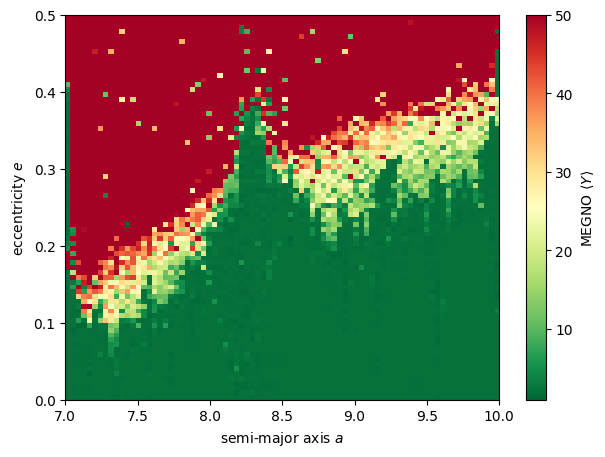

In [5]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.set_title('Brute force grid')
extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d, interpolation="none", vmin=1, vmax=50, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")

In [6]:
from astroqtpy.quadtree import NbodyQuadTree

In [7]:
# define parameter range
x_min, x_max = 7, 10
y_min, y_max = 0, 0.5

In [8]:
# initialize NbodyQuadTree
nbody_tree = NbodyQuadTree(x_min, x_max, y_min, y_max, megno_whfast_simulation,
                           split_threshold=0.5,
                           N_points=1,
                           N_proc=1,
                           max_depth=7,
                           verbose=False,
                           filename_points='./tutorial_outputs/nbodytree_points.txt',
                           filename_nodes='./tutorial_outputs/nbodytree_nodes.txt'
                           )

In [9]:
nbody_tree.run_quadtree()

Attempting to load previous results...
   No previous results found, starting new...
DONE! :)


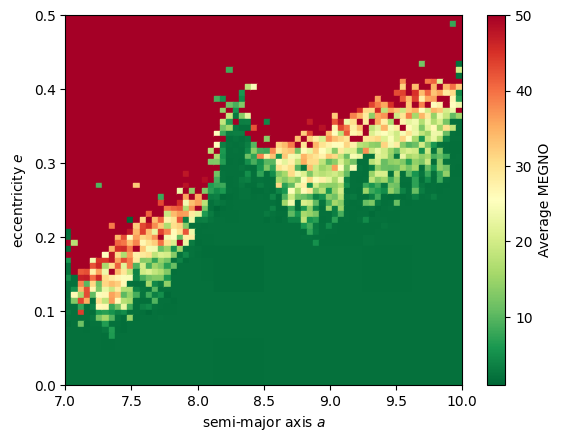

In [12]:
# make figure
fig, ax = plt.subplots()
ax.set_title('With astro-QTpy')
quadtree_map = nbody_tree.draw_tree(ax, vmin=1, vmax=50, show_lines=False)
plt.colorbar(quadtree_map, ax=ax, label='Average MEGNO')
ax.set_xlabel("semi-major axis $a$")
ax.set_ylabel("eccentricity $e$")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
fig.savefig('./tutorial_outputs/nbodytree_plot.png', dpi=200)

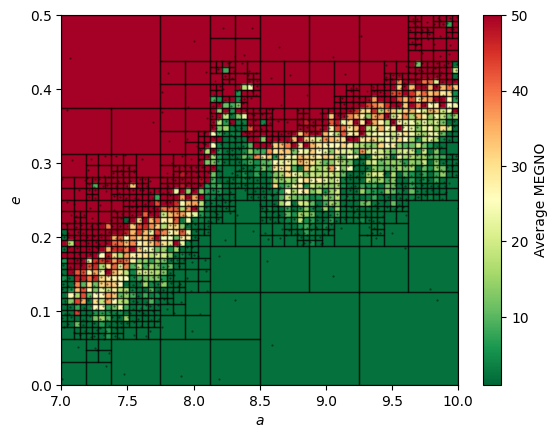

In [10]:
# make figure
fig, ax = plt.subplots()
quadtree_map = nbody_tree.draw_tree(ax, vmin=1, vmax=50, show_lines=True, show_points=True)
plt.colorbar(quadtree_map, ax=ax, label='Average MEGNO')
ax.set_xlabel("semi-major axis $a$")
ax.set_ylabel("eccentricity $e$")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
fig.savefig('./tutorial_outputs/nbodytree_plot.png', dpi=200)